<a href="https://colab.research.google.com/github/Rukundo725/Industry---Casualty-Challenge/blob/casual-inference/notebooks/casual_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cd '/content/drive/MyDrive/week 7/data'

In [ ]:
pip install causalgraphicalmodels


In [ ]:
pip install causalnex

  Using cached wrapt-1.11.2-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.12.1
    Uninstalling wrapt-1.12.1:
      Successfully uninstalled wrapt-1.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires wrapt~=1.12.1, but you have wrapt 1.11.2 which is incompatible.


In [ ]:
! apt install libgraphviz-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
! pip install pygraphviz

In [ ]:
! pip install wrapt --upgrade

  Using cached wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.11.2
    Uninstalling wrapt-1.11.2:
      Successfully uninstalled wrapt-1.11.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
causalnex 0.10.0 requires wrapt<1.12,>=1.11.0, but you have wrapt 1.12.1 which is incompatible.


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from causalgraphicalmodels import CausalGraphicalModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from causalnex.structure.notears import from_pandas, from_pandas_lasso
import pygraphviz
import networkx as nx
# import gspread as gs
# from google.colab import auth
# auth.authenticate_user()
from oauth2client.client import GoogleCredentials
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/week 7/data/data.csv")


In [ ]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [20]:
# Drop unnecessary columns

data.drop(["id", "Unnamed: 32"], axis=1, inplace=True)

In [21]:
fields = ["mean", "se", "worst"]
columns = ["radius", "texture", "perimeter", "area", "smoothness", "compactness", "concavity", "concave points", "symmetry", "fractal_dimension"]

In [25]:
# We can transform outlier to the mean of each column for better modeling
for col in range(len(columns)):
    
    for f in range(len(fields)):
        
        Q1 = data[columns[col]+"_"+fields[f]].quantile(0.25)
        Q3 = data[columns[col]+"_"+fields[f]].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5*IQR
        upper_bound = Q3 + 1.5*IQR
        
        outliers = (data[columns[col]+"_"+fields[f]] < lower_bound) | (data[columns[col]+"_"+fields[f]] > upper_bound)
        data[columns[col]+"_"+fields[f]][outliers] = data[columns[col]+"_"+fields[f]].mean()

FEATURE EXTRACTION AND SCALING.

The code used in this section is adapted from https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/PCA/PCA_Data_Visualization_Iris_Dataset_Blog.ipynb

In [26]:
# splitting dataset into labels and features
x= data.drop("diagnosis", axis=1)   # our features
y = data.diagnosis                   # our label

In [27]:
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [28]:

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [30]:
finalDf = pd.concat([principalDf, data[['diagnosis']]], axis = 1)

In [31]:
finalDf.head()

,principal component 1,principal component 2,diagnosis
0,4.590749,-1.707968,M
1,2.075852,2.992511,M
2,6.817807,0.033780,M
3,3.107988,-2.075123,M
4,4.202006,0.774877,M


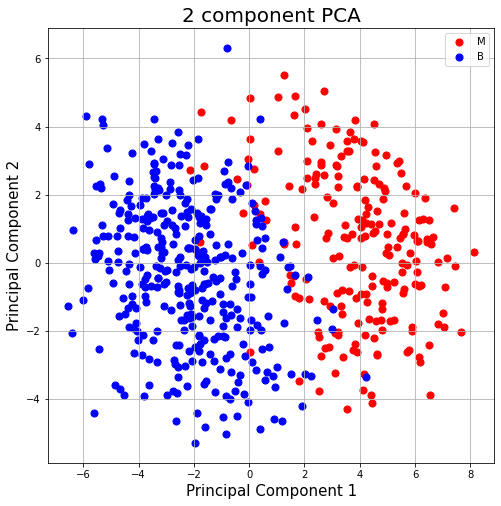

In [32]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['M', 'B']
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['diagnosis'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

The components distinguish between the classes quite well with a little overlap

In [33]:
pca.explained_variance_ratio_

array([0.40712156, 0.16002692])

The first component explains 40% of the variation, while the second component explains 16% of the variation. The two components used together will explain 56% of the variation. Adding a third component may improve the variation explained by the components.


Using PCA for feature selection would allow us to observe the number of components but it would be difficult to explain the features influencing the outcome when plotting causal graphs and inputting the components chosen into an algorithm for training. In the next section we explore methods that we can use for feature selection while preserving the variables as they are.


## FEATURE SELECTION
Several methods can be applied to do feature selection. Some are listed below:

Using correlation - use the correlation matrix to check which variable are highly correlated and retain only one of the correlated variables.
Univariate feature selection
Recursive feature elimination (forward or backward elimination can be applied)
Recursive feature elimination with cross validation
Tree based feature selection
The first four models can be tested by training a classification algorithm and checking the evaluation metrics.

Here we will use tree based feature selection to extract feature importance and determine the number of features to use.



In [35]:

#encode diagnosis column (any non-numeric columns in the dataset)
# Malignant = 1
# Benign = 0
le = LabelEncoder()
data['diagnosis'] = le.fit_transform(data['diagnosis'])
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.000000,0.11840,0.104341,0.088799,0.046696,0.241900,0.062184,0.405172,0.9053,2.866059,40.337079,0.006399,0.049040,0.05373,0.01587,0.030030,0.006193,15.849535,17.33,104.594461,880.583128,0.162200,0.254265,0.7119,0.2654,0.290076,0.081695
1,1,20.57,17.77,132.90,610.265602,0.08474,0.078640,0.086900,0.070170,0.181200,0.056670,0.543500,0.7339,3.398000,29.720313,0.005225,0.013080,0.01860,0.01340,0.013890,0.003532,15.849535,23.41,158.800000,880.583128,0.123800,0.186600,0.2416,0.1860,0.275000,0.089020
2,1,19.69,21.25,130.00,610.265602,0.10960,0.159900,0.197400,0.127900,0.206900,0.059990,0.355081,0.7869,4.585000,40.337079,0.006150,0.040060,0.03832,0.02058,0.022500,0.004571,23.570000,25.53,152.500000,784.923040,0.144400,0.424500,0.4504,0.2430,0.361300,0.087580
3,1,11.42,20.38,77.58,386.100000,0.09636,0.104341,0.241400,0.105200,0.181162,0.062798,0.495600,1.1560,3.445000,27.230000,0.009110,0.025478,0.05661,0.01867,0.020542,0.003795,14.910000,26.50,98.870000,567.700000,0.132369,0.254265,0.6869,0.2575,0.290076,0.083946
4,1,20.29,14.34,135.10,610.265602,0.10030,0.132800,0.198000,0.104300,0.180900,0.058830,0.355081,0.7813,2.490880,40.337079,0.011490,0.024610,0.05688,0.01885,0.017560,0.005115,22.540000,16.67,152.200000,784.923040,0.137400,0.205000,0.4000,0.1625,0.236400,0.076780


### Split the dataset into train, validation and test sets

In [36]:
X = data.drop(["diagnosis"], axis=1)
y = data["diagnosis"]

In [37]:
# standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [38]:
# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.10, random_state=42
)

### Train and predict using random forest classifier

In [39]:
# create the classifier
classifier = RandomForestClassifier(n_estimators=100)

In [40]:
# Train the model using the training sets
classifier.fit(X_train, y_train)

RandomForestClassifier()

In [41]:
# predictin on the test set
y_pred = classifier.predict(X_test)

In [42]:
rf_cnm=confusion_matrix(y_test, y_pred)
print('log_results') 
print ('Accuracy Score :',accuracy_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))

log_results
Accuracy Score : 1.0
Precision: 1.0
Recall: 1.0


Text(0.5, 15.0, 'Predicted label')

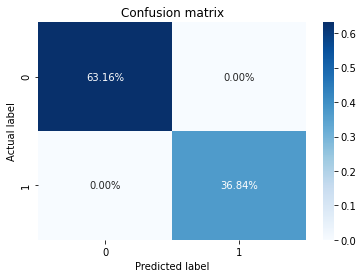

In [43]:
# create heatmap
sns.heatmap(rf_cnm/np.sum(rf_cnm), annot=True ,fmt='.2%', cmap='Blues')
ax.xaxis.set_label_position("top")
#plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

The evaluation metrics show that the model is performing  well with no errors

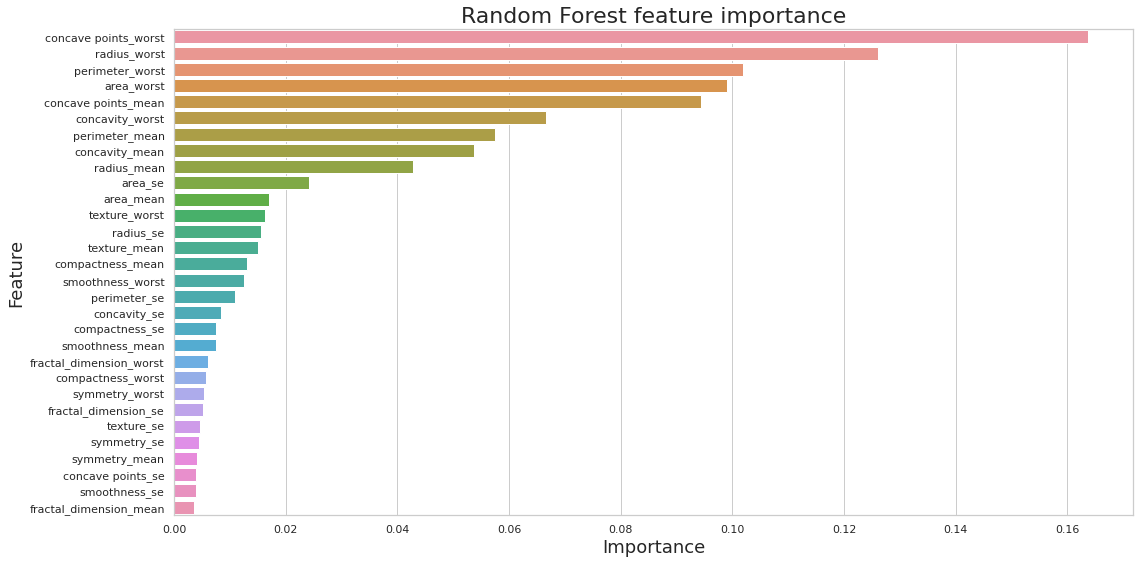

In [44]:
# get importance
importances = classifier.feature_importances_
labels = X.columns
feature_df = pd.DataFrame(list(zip(labels, importances)), columns=["feature", "importance"])
feature_df = feature_df.sort_values(by='importance', ascending=False, )

# image formatting
axis_fs = 18  # fontsize
title_fs = 22  # fontsize
sns.set(style="whitegrid")

plt.figure(figsize=(16, 8))
ax = sns.barplot(x="importance", y="feature", data=feature_df)
ax.set_xlabel('Importance', fontsize=axis_fs)
ax.set_ylabel('Feature', fontsize=axis_fs)  # ylabel
ax.set_title('Random Forest feature importance', fontsize=title_fs)


plt.tight_layout()
# plt.savefig("feature_importance.png", dpi=120)
plt.show()

Since the model has a good performance we can use it to choose the values that are important. The plot above ranks the features based on their importance. A scree plot can be used to determine the number of features to retain in PCA, with a random forest we can 'get_support' from the tained model.

In [45]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)
sel.get_support()
selected_feat= X.columns[(sel.get_support())]
selected_feat

Index(['perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean',
       'radius_worst', 'perimeter_worst', 'area_worst', 'concavity_worst',
       'concave points_worst'],
      dtype='object')


We have 8 features that have been chosen as important, and the features also have a high importance from the graph of important features. The dataset input into the causalnex package will contain these 8 features

# CASUAL GRAPHS

In [56]:
#filter original dataset to retain the important variables
#the dimension of the dataset has reduced from 569,32 to 569,9
causal_data = data[['diagnosis','perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean',
       'radius_worst', 'perimeter_worst', 'area_worst', 'concavity_worst',
       'concave points_worst']].copy()
causal_data.head()

,diagnosis,perimeter_mean,area_mean,concavity_mean,concave points_mean,radius_worst,perimeter_worst,area_worst,concavity_worst,concave points_worst
0,1,122.80,1001.000000,0.088799,0.046696,15.849535,104.594461,880.583128,0.7119,0.2654
1,1,132.90,610.265602,0.086900,0.070170,15.849535,158.800000,880.583128,0.2416,0.1860
2,1,130.00,610.265602,0.197400,0.127900,23.570000,152.500000,784.923040,0.4504,0.2430
3,1,77.58,386.100000,0.241400,0.105200,14.910000,98.870000,567.700000,0.6869,0.2575
4,1,135.10,610.265602,0.198000,0.104300,22.540000,152.200000,784.923040,0.4000,0.1625


In [57]:
causal_data.shape

(569, 10)

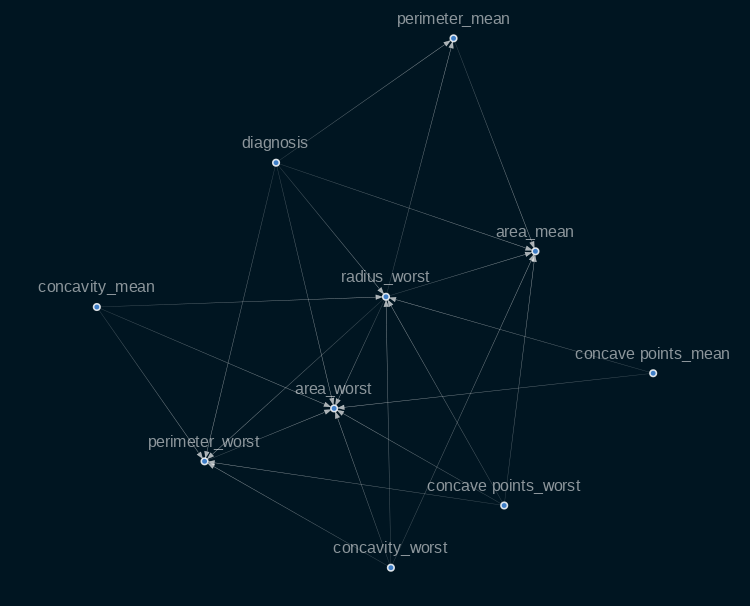

In [59]:
sm = from_pandas(causal_data, w_threshold=0.8)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "2.0", 'size':2.5},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

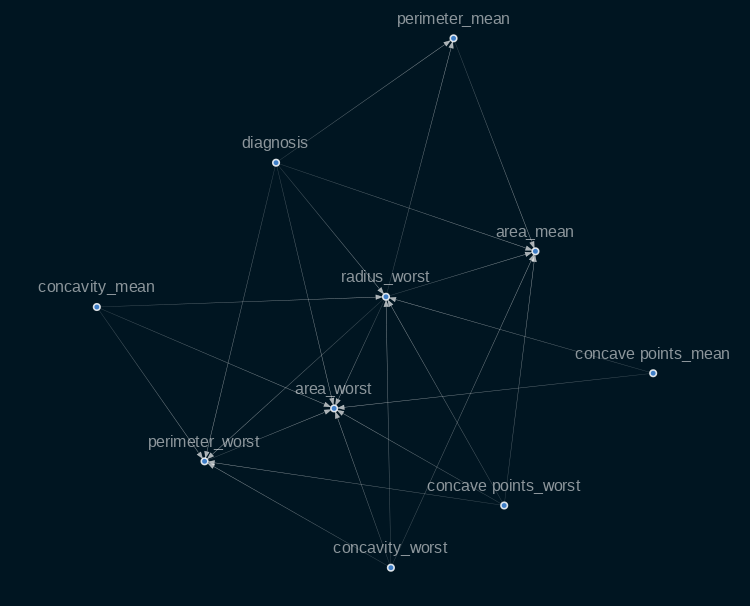

In [60]:
sm = from_pandas(causal_data, w_threshold=0.8)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "2.0", 'size':2.5},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

In this graph the outcome variable(diagnosis) is the one influencing the other variables, to avoid this we will add a constraint that prevents it from being a parent to any of the nodes. We will first add the constraint without lasso constraint and because of the small amount of data we will also draw the graph with lasso regularization.

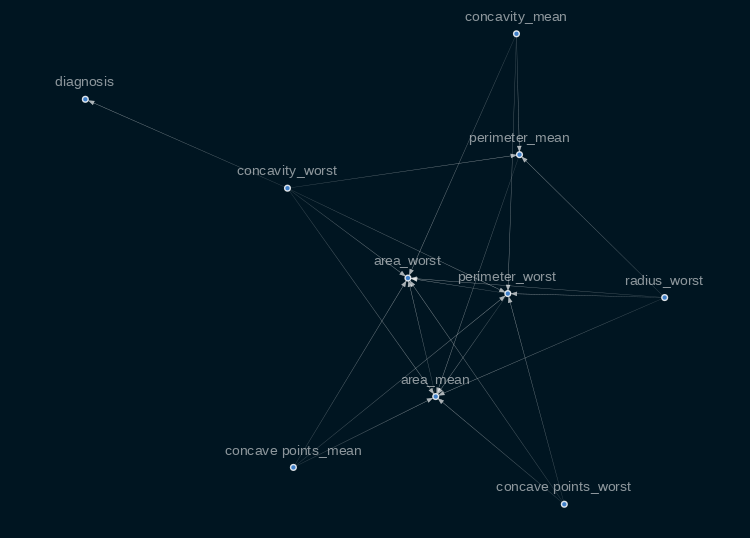

In [61]:
#add constraint to diagnosis without lasso regularization
sm_constrained = from_pandas(causal_data, tabu_parent_nodes=['diagnosis'], w_threshold=0.8)
viz = plot_structure(
    sm_constrained,
    graph_attributes={"scale": "2.0", 'size':2.5},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

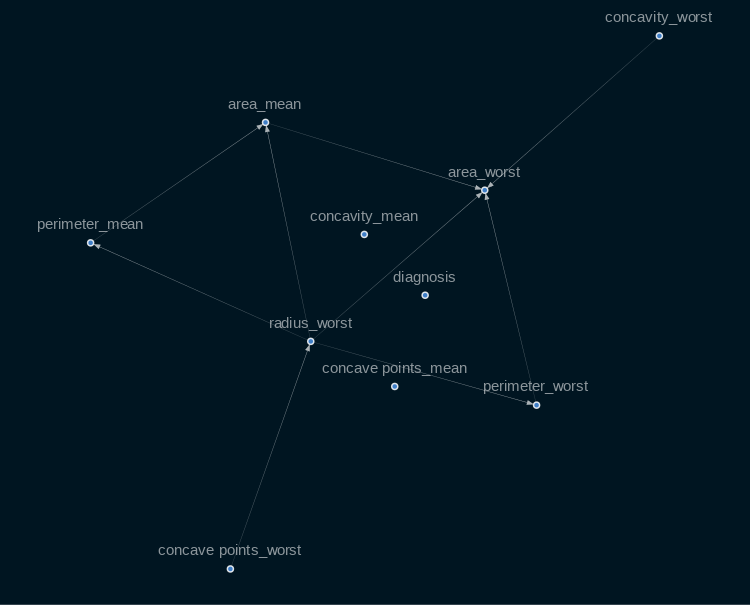

In [62]:

#put constraint on diagnosis column with lasso regularization
sm_lasso_constrained = from_pandas_lasso(causal_data, tabu_parent_nodes=['diagnosis'], w_threshold=0.8, beta=0.8)
viz = plot_structure(
    sm_lasso_constrained,
    graph_attributes={"scale": "2.0", 'size':2.5},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

Structure Review

Radius affects perimeter and area,

concavity affects radius and eventually perimeter and area,

the graph captures these relationships.

### Jaccard's similarity index
Using intersection

In [63]:
#similarity between a graph plotted without lasso regularization and one plotted with lasso regularization
def jaccard_similarity(g, h):
    i = set(g).intersection(h)
    return round(len(i) / (len(g) + len(h) - len(i)),3)

jaccard_similarity(sm_constrained.edges(), sm_lasso_constrained.edges())

0.348


Using Union and intersection

In [64]:
def Jaccar_score(g, h):    
    i = set(g).intersection(set(h))
    u = set(g).union(set(h))
    return len(i) / float(len(u))


Split the data rowwise and test the model as we increase the data

In [65]:
df_1 = causal_data.iloc[:100,:]
df_2 = causal_data.iloc[:300,:]
df_3 = causal_data.iloc[:,:]

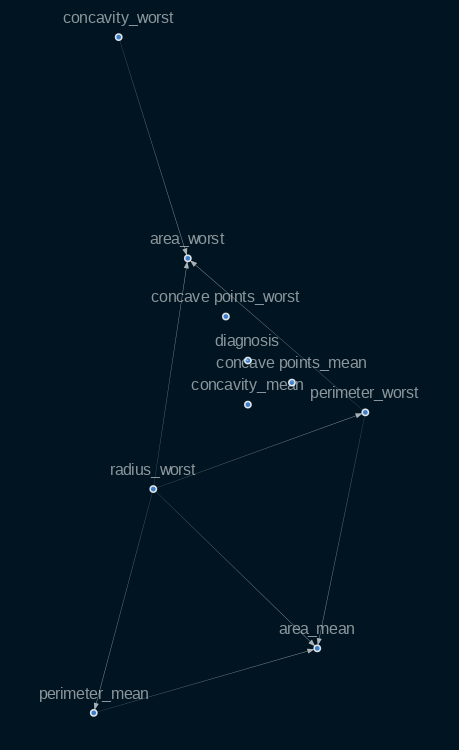

In [66]:
sm_df1 = from_pandas_lasso(df_1, tabu_parent_nodes=['diagnosis'], w_threshold=0.8, beta=0.8)
viz = plot_structure(
    sm_df1,
    graph_attributes={"scale": "2.0", 'size':2.5},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))


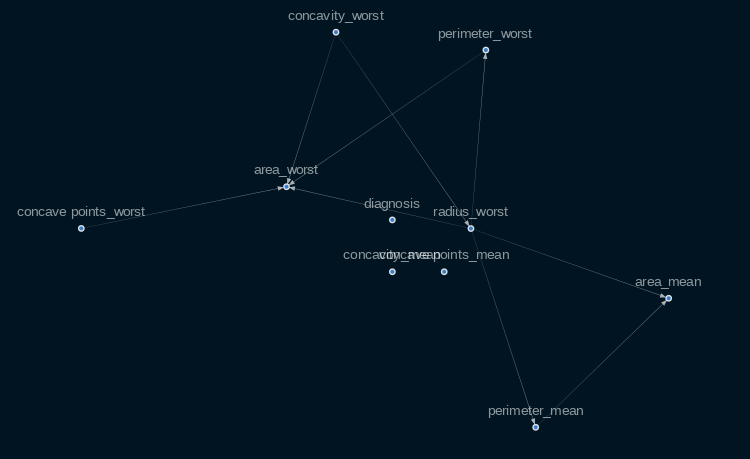

In [67]:
sm_df2 = from_pandas_lasso(df_2, tabu_parent_nodes=['diagnosis'], w_threshold=0.8, beta=0.8)
viz = plot_structure(
    sm_df2,
    graph_attributes={"scale": "2.0", 'size':2.5},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

In [68]:
# similarity between df_1 and df_2
jaccard_similarity(sm_df1.edges(), sm_df2.edges())

0.7

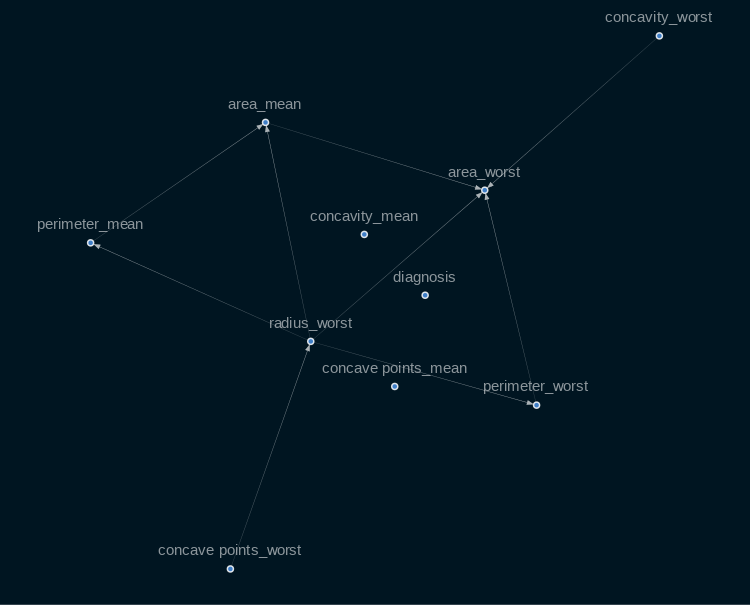

In [69]:
sm_df3 = from_pandas_lasso(df_3, tabu_parent_nodes=['diagnosis'], w_threshold=0.8, beta=0.8)
viz = plot_structure(
    sm_df3,
    graph_attributes={"scale": "2.0", 'size':2.5},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

In [70]:

# similarity between df_2 and df_3
jaccard_similarity(sm_df2.edges(), sm_df3.edges())

0.636

In [71]:
# similarity between df_1 and df_3
jaccard_similarity(sm_df1.edges(), sm_df3.edges())

0.7

In [72]:
df_4 = causal_data.iloc[:200,:]
df_5 = causal_data.iloc[:400,:]


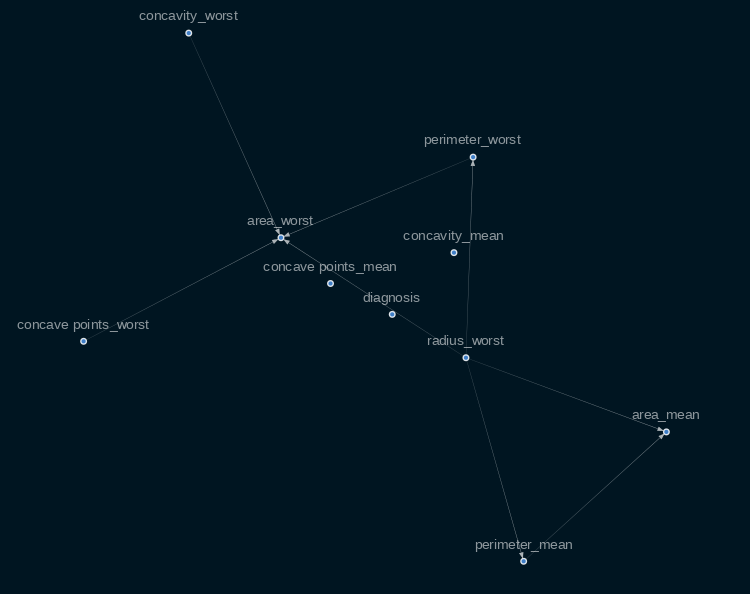

In [73]:
sm_df3 = from_pandas_lasso(df_4, tabu_parent_nodes=['diagnosis'], w_threshold=0.8, beta=0.8)
viz = plot_structure(
    sm_df3,
    graph_attributes={"scale": "2.0", 'size':2.5},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

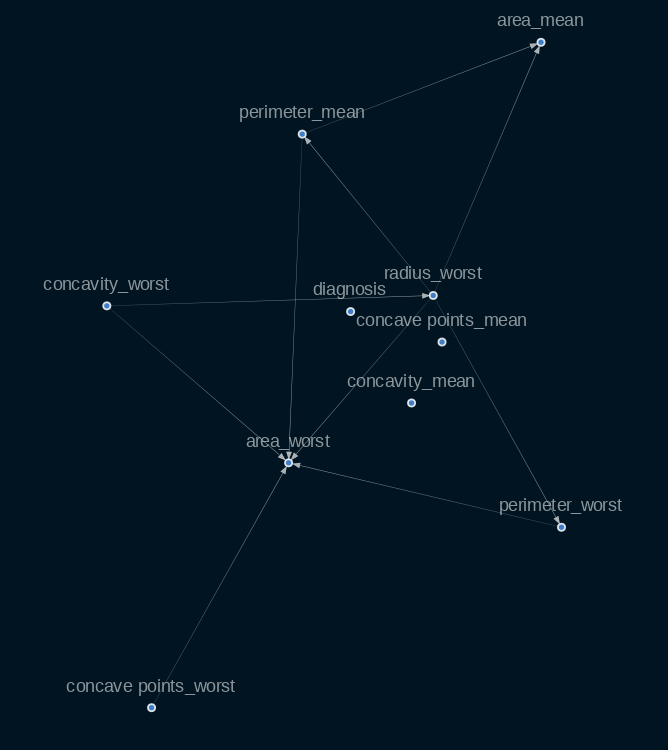

In [74]:
sm_df3 = from_pandas_lasso(df_5, tabu_parent_nodes=['diagnosis'], w_threshold=0.8, beta=0.8)
viz = plot_structure(
    sm_df3,
    graph_attributes={"scale": "2.0", 'size':2.5},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

In [75]:
# similarity between df_1 and df_4
jaccard_similarity(sm_df2.edges(), sm_df3.edges())

0.9

In [76]:
# similarity between df_1 and df_5
jaccard_similarity(sm_df2.edges(), sm_df3.edges())

0.9

In [77]:
# similarity between df_4 and df_5
jaccard_similarity(sm_df2.edges(), sm_df3.edges())

0.9

In [78]:
# similarity between df_2 and df_5
jaccard_similarity(sm_df2.edges(), sm_df3.edges())

0.9

In [79]:
# similarity between df_3 and df_5
jaccard_similarity(sm_df2.edges(), sm_df3.edges())

0.9

The graph has similarity of O.9 

FINAL GRAPH

If radius affects, area and perimeter, we will add the relationships, below, radius will not directly affect the outcome but area, perimeter and concavity will affect the outcome

In [80]:
sm_lasso_constrained.add_edge("concave_points_mean", "diagnosis")
sm_lasso_constrained.add_edge("concave_points_worst", "diagnosis")
sm_lasso_constrained.add_edge("concavity_mean", "diagnosis")
sm_lasso_constrained.add_edge("area_worst", "diagnosis")
sm_lasso_constrained.add_edge("area_mean", "diagnosis")
sm_lasso_constrained.add_edge("concavity_worst", "diagnosis")
sm_lasso_constrained.add_edge("perimeter_worst", "diagnosis")

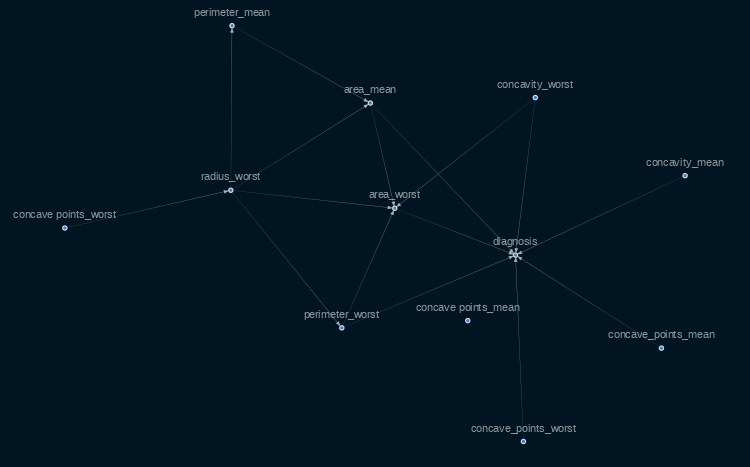

In [81]:

viz = plot_structure(
    sm_lasso_constrained,
    graph_attributes={"scale": "2.0", 'size':2.5},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))